<a href="https://colab.research.google.com/github/RamSaw/deep-unsupervised-learning/blob/master/HW01_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 2.1 MLP

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import tqdm
from mpl_toolkits.mplot3d import Axes3D
SEED = 24839
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

(200, 200)


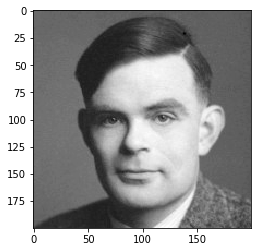

In [2]:
distribution = np.load('./distribution.npy')
print(distribution.shape)
plt.imshow(distribution, cmap='gray')

In [0]:
def plot_3D_dist(dist):
  fig = plt.figure(figsize=(13, 7))
  ax = plt.axes(projection='3d')
  X1 = np.arange(200)
  X2 = np.arange(200)
  X1, X2 = np.meshgrid(X1, X2)
  surf = ax.plot_surface(X1, X2, dist, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
  ax.set_xlabel('x1')
  ax.set_ylabel('x2')
  ax.set_zlabel('PDF')
  ax.set_title('Probability distribution')
  fig.colorbar(surf, shrink=0.5, aspect=5)
  ax.view_init(60, 35)
  plt.show()

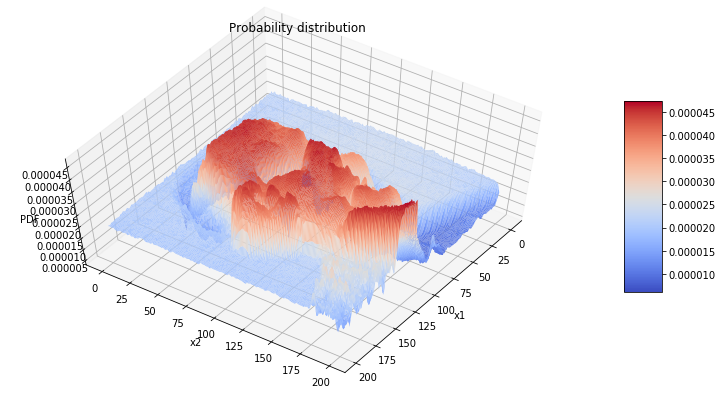

In [4]:
plot_3D_dist(distribution)

In [0]:
def sample_dataset(n):
  flattened = distribution.flatten()
  sampled = np.random.choice(200 * 200, n, p=flattened)
  X1 = (sampled / 200).astype('int').reshape((-1, 1))
  X2 = (sampled % 200).astype('int').reshape((-1, 1))
  return np.hstack((X1, X2))

def X_to_empirical_probs_2D(X):
  probs = np.zeros((200, 200))
  unique, counts = np.unique(X, return_counts=True, axis=0)
  probs[unique[:, 0], unique[:, 1]] += counts
  probs /= len(X)
  return probs

(100000, 2)


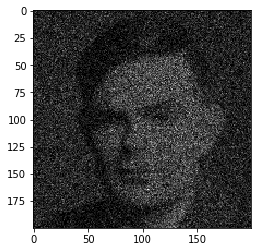

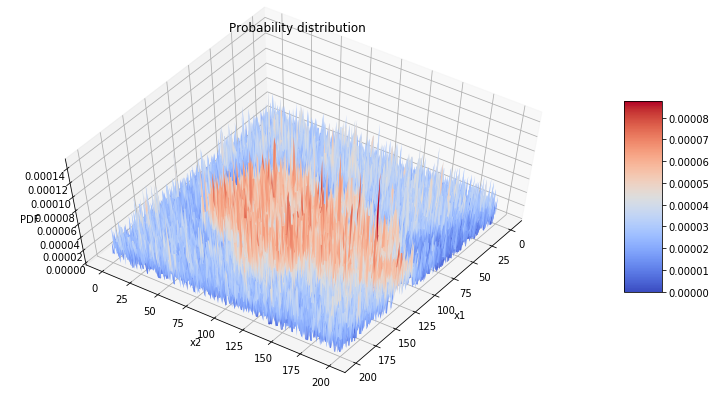

In [6]:
dataset = sample_dataset(100000)
print(dataset.shape)
plt.imshow(X_to_empirical_probs_2D(dataset), cmap='gray')
plot_3D_dist(X_to_empirical_probs_2D(dataset))

In [7]:
X_train_mlp, X_test_mlp = train_test_split(dataset, test_size=0.2, random_state=42)
#X_val_mlp = sample_dataset(int(len(dataset) * 0.01))
X_train_mlp, X_val_mlp = train_test_split(X_train_mlp, test_size=0.125, random_state=22)
X_train_mlp, X_val_mlp, X_test_mlp = torch.tensor(X_train_mlp), torch.tensor(X_val_mlp), torch.tensor(X_test_mlp)
print(X_train_mlp.shape)
print(X_train_mlp[:3])
print(X_val_mlp.shape)
print(X_val_mlp[:3])
print(X_test_mlp.shape)
print(X_test_mlp[:3])

torch.Size([70000, 2])
tensor([[ 49,  96],
        [113, 154],
        [ 83, 127]])
torch.Size([10000, 2])
tensor([[ 87, 147],
        [168,   0],
        [119, 177]])
torch.Size([20000, 2])
tensor([[ 78, 141],
        [ 66, 117],
        [ 35, 199]])


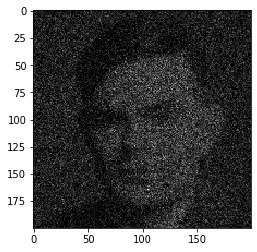

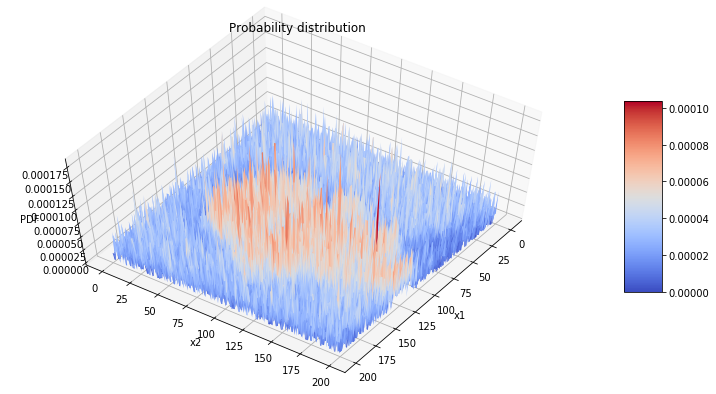

In [8]:
plt.imshow(X_to_empirical_probs_2D(X_train_mlp), cmap='gray')
plot_3D_dist(X_to_empirical_probs_2D(X_train_mlp))

In [9]:
class ModelP1(nn.Module):
  def __init__(self, num_labels):
    super(ModelP1, self).__init__()
    self.thetas = torch.zeros(num_labels, requires_grad=True)

  def forward(self, x1):
    probs = torch.exp(self.thetas[x1]) / torch.sum(torch.exp(self.thetas))
    return probs
  
  def parameters(self):
    return [self.thetas]

def test_ModelP1():
  model = ModelP1(10)
  for param in model.parameters():
      if param.requires_grad:
          print(param.data.shape)
  output = model(torch.tensor([9, 0, 1]))
  print(output.shape)
  print(output)

test_ModelP1()

torch.Size([10])
torch.Size([3])
tensor([0.1000, 0.1000, 0.1000], grad_fn=<DivBackward0>)


In [10]:
class ModelP2(nn.Module):
  def __init__(self, num_labels):
    super(ModelP2, self).__init__()
    self.model = nn.Sequential(
            nn.Linear(num_labels, 400),
            nn.Tanh(),
            nn.Dropout(0.25),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, num_labels),
            nn.Softmax(dim=1)
        )
  
  def forward(self, x2):
    out = self.model(x2)
    return out

def test_ModelP2():
  model = ModelP2(5)
  for param in model.parameters():
      if param.requires_grad:
          print(param.data.shape)
  output = model(torch.tensor([[0, 0, 0, 0, 1], [1.0, 0, 0, 0, 0], [0, 0, 0, 0, 1]]))
  print(output.shape)
  print(output)

test_ModelP2()

torch.Size([400, 5])
torch.Size([400])
torch.Size([200, 400])
torch.Size([200])
torch.Size([5, 200])
torch.Size([5])
torch.Size([3, 5])
tensor([[0.1948, 0.1880, 0.2090, 0.2007, 0.2075],
        [0.1943, 0.1852, 0.2222, 0.2014, 0.1968],
        [0.1882, 0.1979, 0.2156, 0.2070, 0.1913]], grad_fn=<SoftmaxBackward>)


In [11]:
class ModelMlp(nn.Module):
  def __init__(self, num_labels):
    super(ModelMlp, self).__init__()
    self.num_labels = num_labels
    self.model_p1 = ModelP1(num_labels)
    self.model_p2 = ModelP2(num_labels)
  
  def forward(self, x):
    x1, x2 = x[:, 0], x[:, 1]
    probs_x1 = self.model_p1(x1)
    one_hot = torch.zeros((x.shape[0], self.num_labels))
    one_hot[torch.arange(x.shape[0]), x1] = 1
    probs_x2 = self.model_p2(one_hot)
    probs_x2 = probs_x2[np.arange(x.shape[0]), x2]
    return probs_x1 * probs_x2
  
  def parameters(self):
    return list(self.model_p2.parameters()) + self.model_p1.parameters()

def test_ModelMlp():
  model = ModelMlp(5)
  for param in model.parameters():
      if param.requires_grad:
          print(param.data.shape)
  output = model(torch.tensor([[2, 0], [0, 0], [4, 4]]))
  print(output.shape)
  print(output)

test_ModelMlp()

torch.Size([400, 5])
torch.Size([400])
torch.Size([200, 400])
torch.Size([200])
torch.Size([5, 200])
torch.Size([5])
torch.Size([5])
torch.Size([3])
tensor([0.0379, 0.0366, 0.0416], grad_fn=<MulBackward0>)


In [12]:
def loss_function(probs):
  return -torch.sum(torch.log(probs)) / len(probs)

loss_function(torch.tensor([0.2, 0.2, 0.6]))

tensor(1.2432)

In [0]:
def train(X_train, X_val, lr, batch_size, epochs, num_labels):
  trainloader = DataLoader(X_train, batch_size=batch_size)
  model = ModelMlp(num_labels)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  
  num_batches = len(trainloader)
  losses_train = []
  losses_val = []
  for epoch in range(epochs):
    for i, batch in enumerate(trainloader):
      optimizer.zero_grad()
      output = model(batch)
      loss_train = loss_function(output)
      loss_train.backward()
      losses_train.append(np.log2(float(loss_train)) / 2)
      optimizer.step()
      
      with torch.no_grad():
        output = model(X_val)
        loss_val = loss_function(output)
        losses_val.append(np.log2(float(loss_val)) / 2)
    with torch.no_grad():
        output = model(X_val)
        loss_val = loss_function(output)
        print(f'Loss on validation: {np.log2(float(loss_val)) / 2}')
  return model, losses_train, losses_val

In [14]:
model, losses_train, losses_val = train(X_train_mlp, X_val_mlp, 0.1, 200, 20, 200)


Loss on validation: 1.6998260021510043
Loss on validation: 1.6997424953841338
Loss on validation: 1.6996433959676052
Loss on validation: 1.6995005254142046
Loss on validation: 1.6994630913897668
Loss on validation: 1.6994521999411796
Loss on validation: 1.6994508955650527
Loss on validation: 1.699441438767595
Loss on validation: 1.6994820042929983
Loss on validation: 1.6996418311307917
Loss on validation: 1.6999366125468978
Loss on validation: 1.700322605749669
Loss on validation: 1.7009125337585358
Loss on validation: 1.7014101463018096
Loss on validation: 1.7020652765953006
Loss on validation: 1.7025820955240256
Loss on validation: 1.7034015815184733
Loss on validation: 1.703819953987984
Loss on validation: 1.704790833226279
Loss on validation: 1.7050326532982967


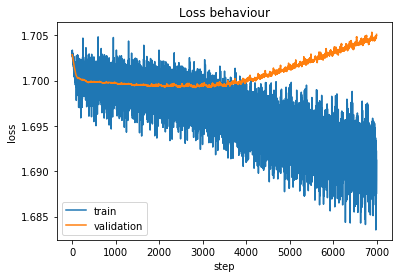

In [15]:
fig, ax = plt.subplots()
ax.set(xlabel='step', ylabel='loss',
       title='Loss behaviour')
ax.plot(np.arange(len(losses_train)), losses_train, label="train")
ax.plot(np.arange(0, len(losses_train)), losses_val, label="validation")
ax.legend()
plt.show()

In [16]:
with torch.no_grad():
  output = model(X_test_mlp)
  loss_test = loss_function(output)
  print(f'Loss on test: {np.log2(float(loss_test)) / 2}')

Loss on test: 1.7047158628996013


In [0]:
def sample_from_model(n, model_p):
  sampled = np.random.choice(200 * 200, n, p=model_p)
  dataset = np.zeros((n, 2))
  X1 = (sampled / 200).astype('int').reshape((-1, 1))
  X2 = (sampled % 200).astype('int').reshape((-1, 1))
  return np.hstack((X1, X2))

0.9997994


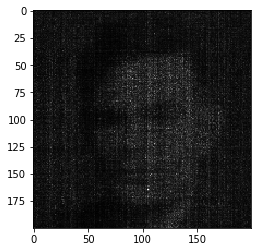

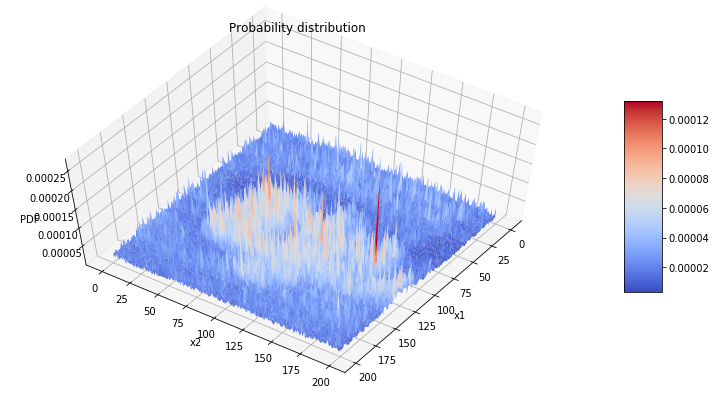

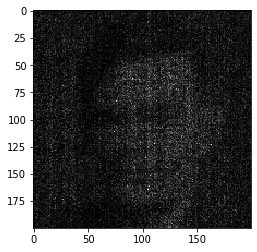

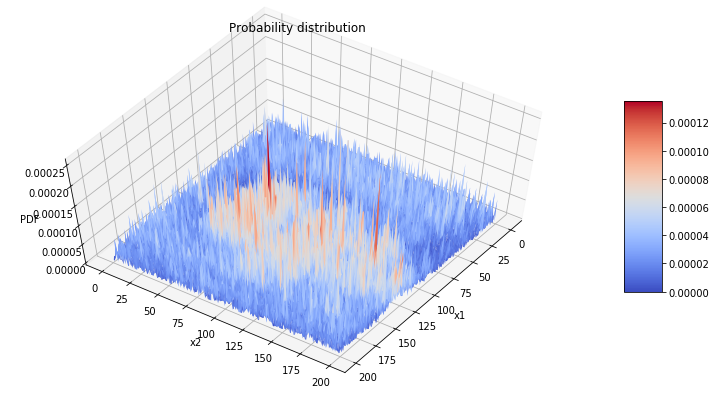

In [18]:
x = np.array([[(i, j) for j in np.arange(200)] for i in np.arange(200)], dtype=np.int64)
x = x.reshape(-1, 2)
model_p = model(x)
model_p = model_p.detach().numpy()
print(np.sum(model_p))
model_p /= np.sum(model_p)
plt.imshow(model_p.reshape((200, 200)), cmap='gray')
plot_3D_dist(model_p.reshape((200, 200)))
sampled_from_model = sample_from_model(100000, model_p)
plt.imshow(X_to_empirical_probs_2D(sampled_from_model), cmap='gray')
plot_3D_dist(X_to_empirical_probs_2D(sampled_from_model))